In [1]:
import sys
sys.path.append('../src/')
from xpcs import *
from sims import *
from autocorrelations import *
import cv2
from scipy.special import erfinv
import pyopencl as cl

%matplotlib notebook


$$\bf{Notes}$$

$$
\begin{align}
&\text{-Place plotting at the end of each cell for potentially supressing plotting later} \\
&\text{-Normalize by taking rings of constant intensity and divide by.}   \\
&\text{-Take Contrast maps 3x3 bins??? Ask Oleg again} \\
&\text{-Plot all the rois on one plot. Try changing the center of the masks, binsize, numRings, numSlices and see if the results are consistent} \\
&\text{-At 20 nm, $\beta$ changes, check the FWHM of the peak. Complete the preliminary analysis for November 14th LGES} \\
&\text{-Vegard's law} \\
&\text{|F(Q,t)| = aexp(-(t/$\tau_f$)^$\beta$) + (1-a)exp(-(t/$\tau_s$)^$\beta$)}
\end{align}
$$

# User Defined Variables 

In [2]:
### File Parameters ###
Particle = 2 #2,3
Temperature = 298 #[298,305,315,325,345,365,385,405,350_cool]
Scan = 219 #P2: [219,334,416,552,579,709,779,796,868], P3:[239,356



### Analysis Parameters ###

#Crop Size
#number of standard deviations from peak
Xv = 5 
Xh = 5

#Binning Parameters
#Number of pixels in every direction to bin
#A bin size of 1 does not bin
binSize = 5

#Mask Parameters
numRings = 10  # Number of elliptical rings
numSlices = 4 # Number slices, should be even

# Dark Time, in seconds
framespacing = 1 #1,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5


#Constants 
notzero = 1.0**(-12)

# File Paths

In [3]:
dir_path = "/Users/eriklamb/Documents/Data/PETRA/PETRA_P10_November2023/Beamtime_11017686/XPCS_Scans/Particle_{}/{}K/NPS_01_00{}/e4m/".format(Particle,Temperature,Scan)
results_path = "/Users/eriklamb/Documents/Data/PETRA/PETRA_P10_November2023/Beamtime_11017686/XPCS_Scans/Particle_{}/{}K/NPS_01_00{}/result/".format(Particle,Temperature,Scan)

# Load Data

In [4]:
#Check that path exists
if not os.path.exists(dir_path):
    print(f"Directory '{dir_path}' Does Not Exist!")

#Load File Names
file_list = np.sort(os.listdir(dir_path)).tolist()

#Remove first element if it's DS_Store
if file_list[0] == '.DS_Store':
    file_list.remove(file_list[0])
    
for f in file_list:
    print(f)
 
# Retrieve number of files
num_files = len(file_list)

NPS_01_00219.batchinfo
NPS_01_00219_data_000001.h5
NPS_01_00219_master.h5
NPS_01_10219.batchinfo
mask219.mat
mask219_2.mat
mask219_3.mat
mask219_cr.mat


In [5]:
#Set the file name
filename = dir_path+file_list[2]

with h5py.File(filename, 'r') as f:
    print_h5_item(f)

/entry
    /data
        /data_000001
            [Dataset] Shape: (900, 2167, 2070), Type: uint32
    /instrument
        /beam
            /incident_wavelength
                [Dataset] Shape: (), Type: float32
        /detector
            /beam_center_x
                [Dataset] Shape: (), Type: float32
            /beam_center_y
                [Dataset] Shape: (), Type: float32
            /bit_depth_image
                [Dataset] Shape: (), Type: int32
            /bit_depth_readout
                [Dataset] Shape: (), Type: int32
            /count_time
                [Dataset] Shape: (), Type: float32
            /countrate_correction_applied
                [Dataset] Shape: (), Type: int32
            /description
                [Dataset] Shape: (), Type: |S17
            /detectorSpecific
                /auto_summation
                    [Dataset] Shape: (), Type: int32
                /calibration_type
                    [Dataset] Shape: (), Type: |S9
                

                    /vcmp_1
                        [Dataset] Shape: (), Type: uint32
                    /vcmp_2
                        [Dataset] Shape: (), Type: uint32
                    /vcmp_3
                        [Dataset] Shape: (), Type: uint32
                    /vdda
                        [Dataset] Shape: (), Type: uint32
                    /vddc
                        [Dataset] Shape: (), Type: uint32
                    /vddd
                        [Dataset] Shape: (), Type: uint32
                    /vdddio
                        [Dataset] Shape: (), Type: uint32
                    /vish
                        [Dataset] Shape: (), Type: uint32
                    /vrfp
                        [Dataset] Shape: (), Type: uint32
                    /vrfs
                        [Dataset] Shape: (), Type: uint32
                    /vtrm
                        [Dataset] Shape: (), Type: uint32
                /detectorModule_011
                    /countrate_c

# Beam and Detector Parameters

In [6]:
#Set the file name
batchinfo = load_batchinfo(dir_path+file_list[0])
#batchinfo

#From .h5 file
wavelength = np.array(h5py.File(filename, 'r')['entry/instrument/beam/incident_wavelength']) #Wavelength [Å]
x_pixel_size = np.array(h5py.File(filename, 'r')['entry/instrument/detector/x_pixel_size/']) # [m]
y_pixel_size = np.array(h5py.File(filename, 'r')['entry/instrument/detector/y_pixel_size/']) # [m]
pixelSize = x_pixel_size*10**3 # [mm]

#From batchinfo
X0 = batchinfo['x0'] #horizontal beam position
Y0 = batchinfo['y0'] #vertical beam position
ttheta = batchinfo['ccdtth'] #Detector posistion [deg]
D = batchinfo['rr'] # Sample to detector [mm]
horBeg = batchinfo['col_beg']
horEnd = batchinfo['col_end']
verBeg = batchinfo['row_beg']
verEnd = batchinfo['row_end']
detDims = np.array([[horBeg, horEnd],[verBeg,verEnd]]) 



# Reduce Data and Plot Speckles

<IPython.core.display.Javascript object>


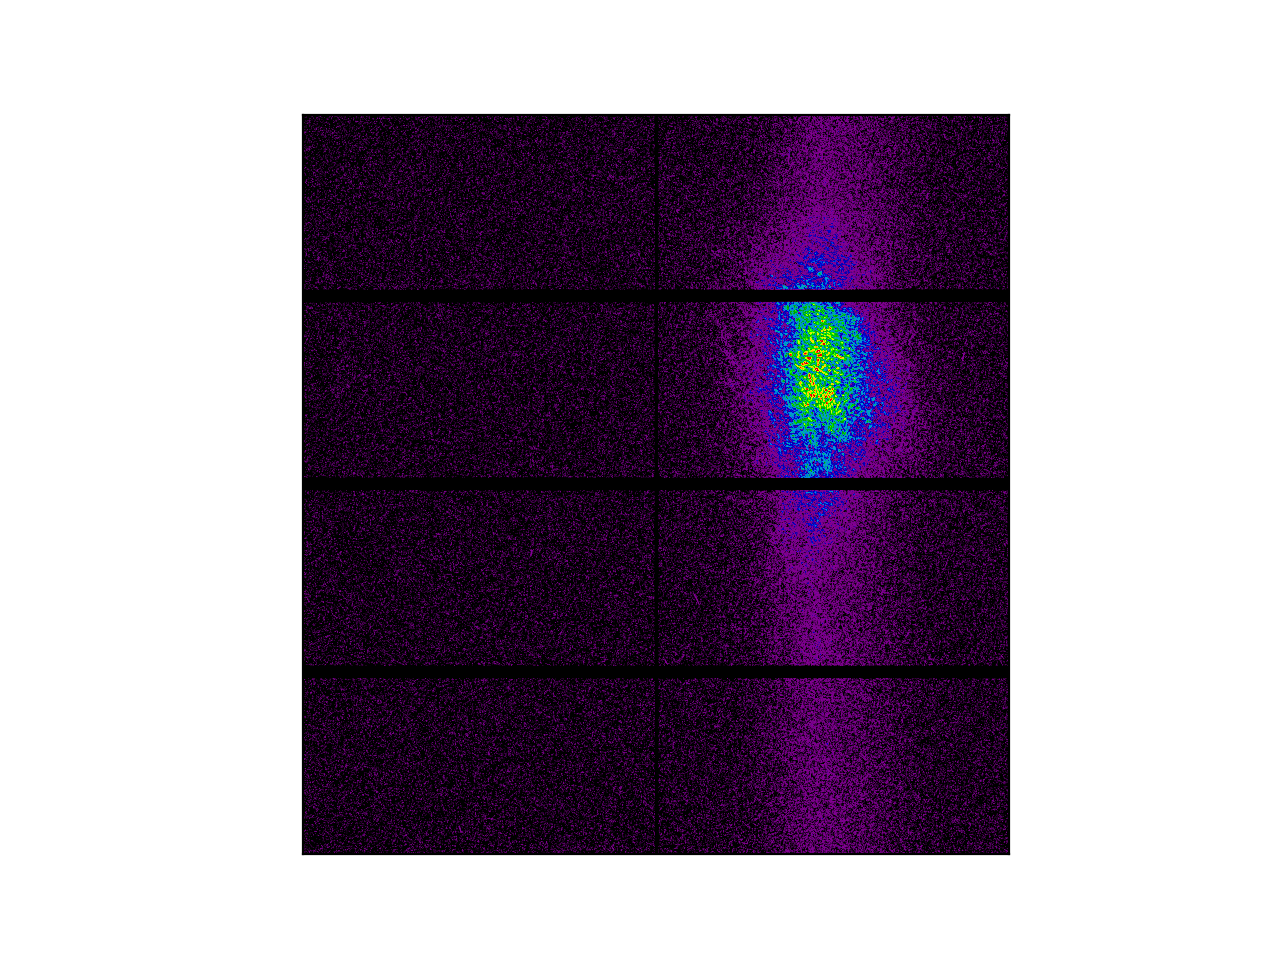

In [7]:
#Load Data
det = np.array(h5py.File(filename, 'r')['entry/data/data_000001/'])[:,:,:] #Used for preprocessing
det_corr = np.copy(det) #Used for g2 correlations

#Remove hot pixels
det[det>1000000] = 0 

### Plotting ###
import matplotlib.pyplot as plt
%matplotlib notebook

fig, ax = plt.subplots()

ax.imshow(np.sum(det[0:5,:,:],axis=0)+1,cmap='nipy_spectral',norm=LogNorm(vmin=1, vmax=35))

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)


# Fit Peak

<IPython.core.display.Javascript object>


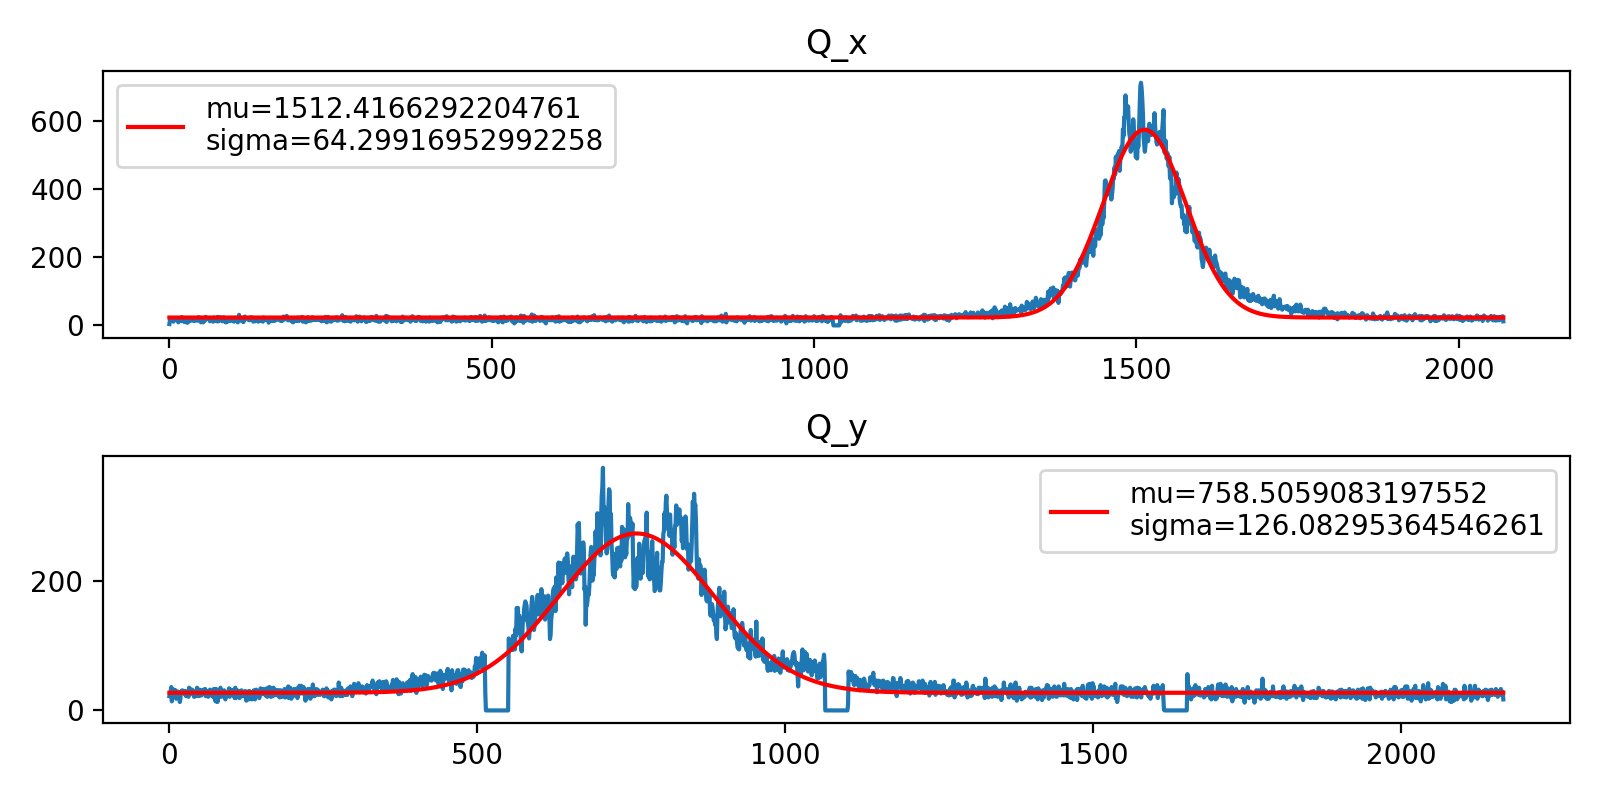

In [8]:
### Sum data along both axes for fitting ###
y1 = np.sum(np.sum(det[0:1,:,:],axis=0),axis=0)
x1 = np.arange(y1.shape[0])

y2 = np.sum(np.sum(det[0:1,:,:],axis=0),axis=1)
x2 = np.arange(y2.shape[0])

popt1, pcov1 = curve_fit(gaussian, x1, y1, p0=[np.max(y1), np.argmax(y1) , 1, np.min(y1[np.nonzero(y1)])])
popt2, pcov2 = curve_fit(gaussian, x2, y2, p0=[np.max(y2), np.argmax(y2) , 1, np.min(y2[np.nonzero(y2)])])

### Plotting ###
import matplotlib.pyplot as plt
%matplotlib notebook

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 4))  # 2 rows, 1 column

# Plot on the first axis
axs[0].plot(y1)
axs[0].plot(x1, gaussian(x1, *popt1), label='mu={}\nsigma={}'.format(popt1[1],popt1[2]), color='red')
axs[0].set_title('Q_x')
axs[0].legend()

# Plot on the second axis
axs[1].plot(y2)
axs[1].plot(x2, gaussian(x2, *popt2), label='mu={}\nsigma={}'.format(popt2[1],popt2[2]), color='red')
axs[1].set_title('Q_y')
axs[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Crop Image

In [9]:
#Peak Locations
hCen = int(np.rint(popt1[1]))
vCen = int(np.rint(popt2[1]))

#Standard Deviations
hSig = int(np.rint(popt1[2]))
vSig = int(np.rint(popt2[2]))

#Set ROI
roi = [vCen-Xv*vSig,vCen+Xv*vSig,hCen-Xh*hSig,hCen+Xh*hSig] #vertical_1, vertical_2, horizontal_1, horizontal_2

#Take subset of detector
det = det[:,roi[0]:roi[1],roi[2]:roi[3]]
det_corr = det_corr[:,roi[0]:roi[1],roi[2]:roi[3]]

# Bin Cropped Data and Plot

<IPython.core.display.Javascript object>


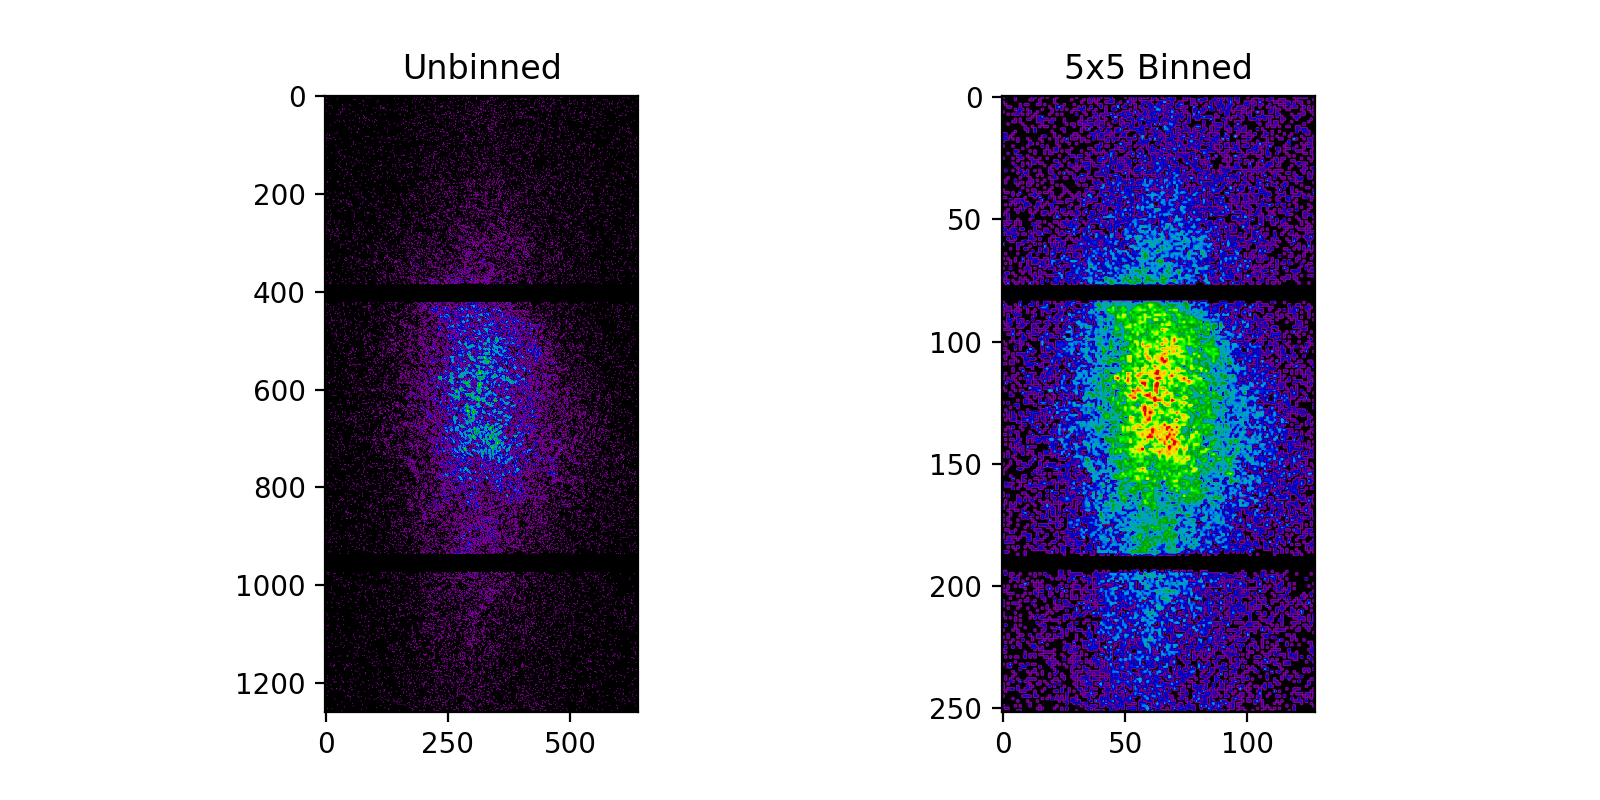

In [10]:
### Binning Section. Bin images as well as the Q maps ###
detBinned,_ = binning(det,binSize,pixelSize,'sum')
det_corr,_ = binning(det_corr,binSize,pixelSize,'sum')



### Plotting ###
import matplotlib.pyplot as plt
%matplotlib notebook

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
#print(det.shape)

axs[0].imshow(np.sum(det[0:1,:,:],axis=0)+1,cmap='nipy_spectral',norm=LogNorm(vmin=1, vmax=35))
axs[0].set_title('Unbinned')

axs[1].imshow(np.sum(detBinned[0:1,:,:],axis=0)+1,cmap='nipy_spectral',norm=LogNorm(vmin=1, vmax=35*binSize))
axs[1].set_title('{}x{} Binned'.format(binSize,binSize))

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

#Det det to binned copy
det = np.copy(detBinned)


# Create Elliptical Masks

In [11]:
#Create Elliptical Masks. Non-masked regions are -1
masks = const_int_mask(det,hSig/binSize,vSig/binSize,3,numRings,numSlices,0.03,0.0001) #Create the masks of equal intensity

#For Plotting. Change -1s to 0s
masks_plot = np.copy(masks)
#masks_plot[masks_plot==-1] = 0

for i in range(masks_plot.shape[0]):
    masks_plot[i,:,:] = (i+1)*masks_plot[i,:,:]

#Sum of the masks for a single mask image
mask_sum = np.sum(masks_plot,axis=0)

[0.4609 0.6768 0.8763 1.0766 1.2601 1.4428 1.6483 1.9536 2.3237 2.8311]


<IPython.core.display.Javascript object>


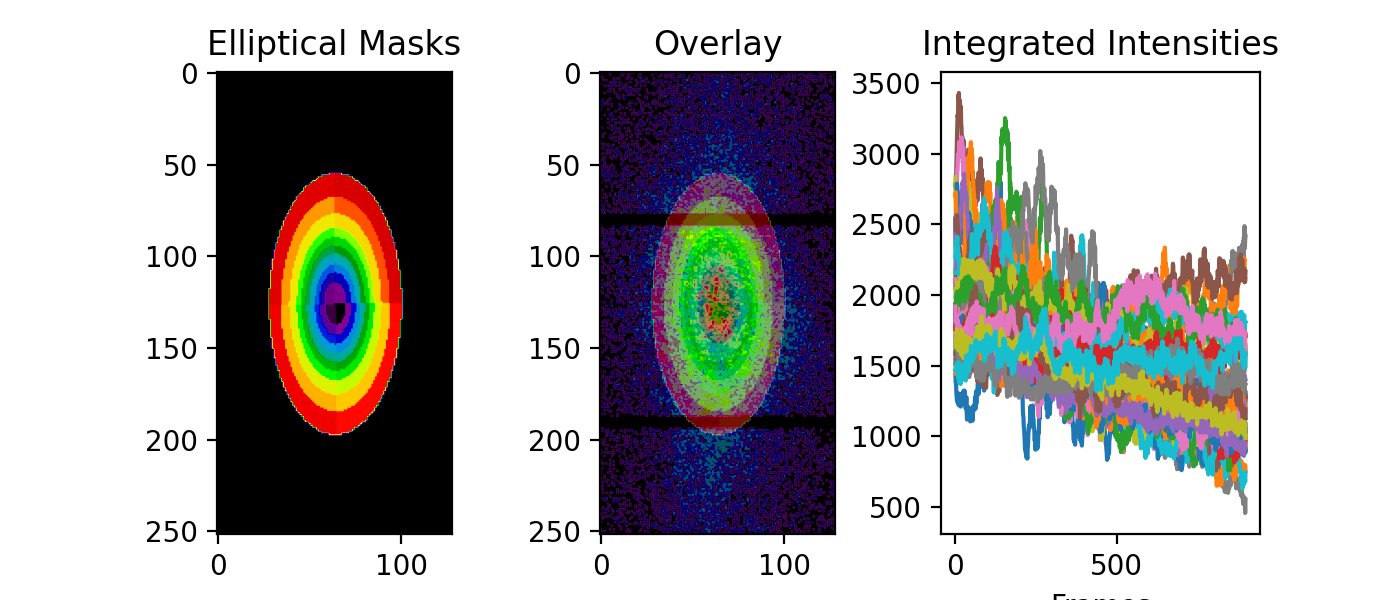

<function matplotlib.pyplot.show(*, block=None)>

In [12]:
### Plotting ###
import matplotlib.pyplot as plt
%matplotlib notebook

fig, axs = plt.subplots(1, 3, figsize=(7, 3))
#print(det.shape)

#Plot the Masks alone, with labels
axs[0].imshow(mask_sum,'nipy_spectral',clim=(1,numRings*numSlices+3.5))
axs[0].set_title('Elliptical Masks')

#Plot the masks overlayed on the detector image
# Display the first image of mask sum
axs[1].imshow(mask_sum-1, cmap='nipy_spectral',clim =(1,numRings*numSlices+3), alpha=1)
# Overlay the second image with a 'plasma' color scale and some transparency
axs[1].imshow(np.sum(det[0:1,:,:],axis=0)+1,cmap='nipy_spectral',norm=LogNorm(vmin=1, vmax=35*binSize),alpha=0.55)
axs[1].set_title('Overlay')

#Plot the integrated intensity of each mask region
i=0
for m in masks: 
    axs[2].plot(np.sum(det[:,m==1],axis=1),label='{}'.format(i+1))
    i+=1
axs[2].set_title('Integrated Intensities')
axs[2].set_xlabel('Frames')
#axs[2].legend()

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.show

#Det det to binned copy
#det = np.copy(detBinned)

# Calculate Q for Each Mask

In [13]:
#Calculate momentum transfer in x and y directions
qx,qy = reciprocal_space_map(wavelength,ttheta,X0,Y0,pixelSize,D,detDims)

#Create a meshgrid to map to the detector shpae
Qx,Qy = np.meshgrid(qx,qy)

#Set to same ROI as the detector
Qx = Qx[roi[0]:roi[1],roi[2]:roi[3]]
Qy = Qy[roi[0]:roi[1],roi[2]:roi[3]]

#Bin the Map according to the same binning as the detector
Qx,_ = binning(Qx,binSize,mode='mean')
Qy,_ = binning(Qy,binSize,mode='mean')


dQ = np.zeros(masks.shape[0])

#Find the center of the peak
Qx0 = Qx[Qx.shape[0]//2,Qx.shape[1]//2]
Qy0 = Qy[Qy.shape[0]//2,Qy.shape[1]//2]

#Calculate the mean displacement from the center for each ROI
for i in range(masks.shape[0]):
    dQ[i] = np.sqrt((np.mean(Qx[masks[i,:,:]==1]))**2+(np.mean(Qy[masks[i,:,:]==1]))**2)

#for mask in masks:
print(dQ)

[2.19635706 2.1989242  2.19933904 2.19674344 2.19511421 2.20005103
 2.20055916 2.19562505 2.1941433  2.20096129 2.20153794 2.19472389
 2.19339223 2.20166252 2.20230234 2.19403673 2.19244609 2.20255564
 2.20325849 2.19315536 2.19166287 2.20326065 2.20405768 2.19246728
 2.19079323 2.20407987 2.20494525 2.19166796 2.18971648 2.20506856
 2.20605139 2.19071095 2.18817234 2.20656516 2.20763547 2.18925645
 2.18621986 2.20839354 2.20965317 2.18749905]


# Main Loop

In [14]:
#Calculate the G2 autocorrelations for the entire image
mask = np.ones(det.shape[1:])

sumI,G2,_,_,_ = g2calc(det_corr,mask)

# Calculate Frame Spacing
nframes = det.shape[0]
dpl = 4
delay = framespacing * finddelays(nframes,dpl,1)

<IPython.core.display.Javascript object>


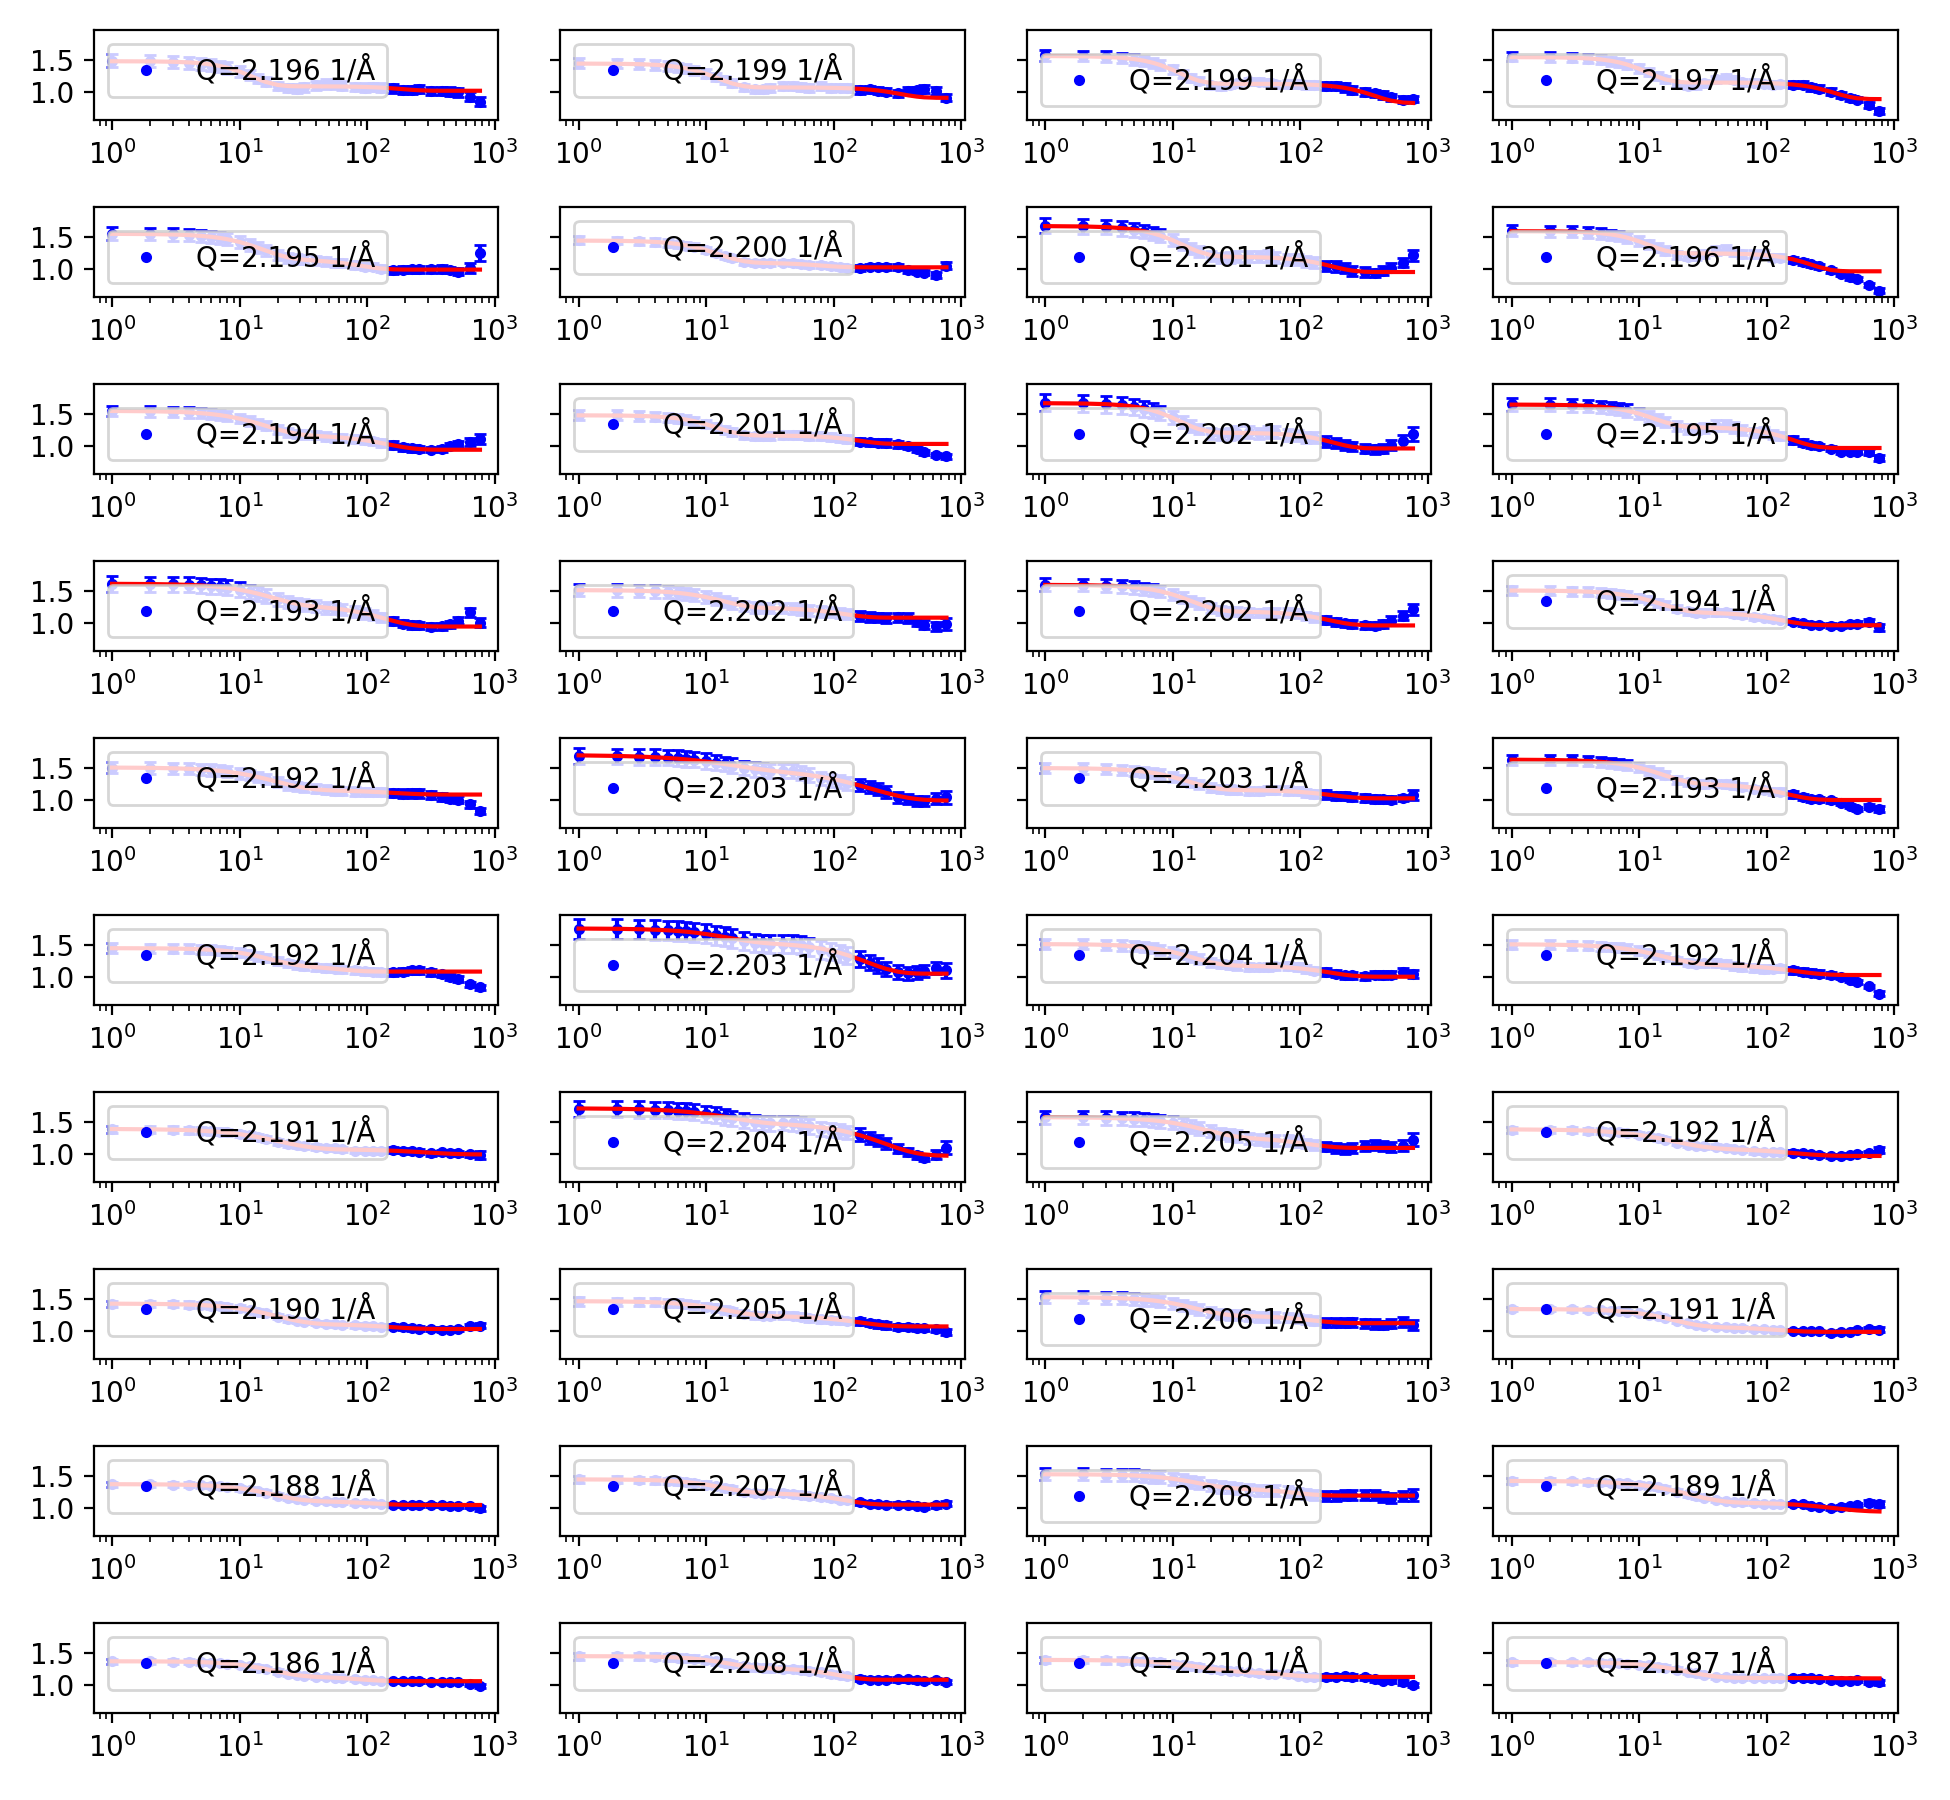

/Users/eriklamb/Documents/Python/Projects/XPCS/notebooks/../src/xpcs.py:53: RuntimeWarning: invalid value encountered in power
  return C+A*np.abs(a*np.exp(-(t/tt1)**b)+(1-a)*np.exp(-(t/tt2)**b))**2


<function matplotlib.pyplot.show(*, block=None)>

In [17]:
#Results Arrays
G2_result = np.zeros((masks.shape[0],delay.shape[1]))
G2_error = np.zeros((masks.shape[0],delay.shape[1]))
taus = np.zeros((masks.shape[0],2)) #Assumes relaxation times
betas = np.zeros(masks.shape[0]) #Assumes one betas
As = np.zeros(masks.shape[0])
aas = np.zeros(masks.shape[0])
Cs = np.zeros(masks.shape[0])

taus_err = np.zeros((masks.shape[0],2)) #Assumes relaxation times
betas_err = np.zeros(masks.shape[0]) #Assumes one betas
As_err = np.zeros(masks.shape[0])
aas_err = np.zeros(masks.shape[0])
Cs_err = np.zeros(masks.shape[0])

if numSlices == 1:
    fig,axs = plt.subplots(numRings,numSlices,figsize=(6,18), sharey=True)
else:
    fig,axs = plt.subplots(numRings,numSlices,figsize=(9.75,9), sharey=True)

# Indices for plotting
i=0
j=0

# Cut last few points from fit
end = -5

for m in masks:
    
    #Used to single out specific scans for truncating the last few points
    if j==numRings*numSlices-1:
        end = -7
        
        
    # Last bit of filtering 
    G2_masked = G2[:,m==1]

    # Removes the detector frames
    hot_pixel_mask = G2_masked[0,:] < 10**(18) 
    #print(hot_mask)
    G2_corr = G2_masked[:,hot_pixel_mask==1]
    #print(G2_corr.shape)
    
    # Average and normalize g2s
    G2_result[j,:] += np.mean(G2_corr/np.mean(det_corr[:,m==1][:,hot_pixel_mask==1])**2,axis=1)[:-1] 
    G2_error[j,:] += np.std(G2_corr/np.mean(det_corr[:,m==1][:,hot_pixel_mask==1])**2,axis=1)[:-1]/np.float32(np.sqrt(G2_corr.shape[1]))
    
    
    #Fit Each G2(Q)
    C = np.min(G2_result[j,:end])
    A = np.max(G2_result[j,:end])-C
    #A2 = 0.5*A1
    a = 0.5
    tt1 = 17
    tt2 = 250
    b = 2
    #b2 = 2

    #Fit the g2s
    popt, pcov = curve_fit(g2_two_tau, delay[0,:end], G2_result[j,:end], p0=[C,A,a,tt1,tt2,b])

    if numSlices == 1:
        #Add to the plots
        axs[j].errorbar(delay[0,:],G2_result[j,:], yerr=G2_error[j,:],fmt='none',ecolor='b',capsize=2)
        axs[j].semilogx(delay[0,:],G2_result[j,:],'b.',label='Q={:.3f} 1/Å'.format(dQ[j]))
        axs[j].semilogx(delay[0,:],g2_two_tau(delay[0,:],*popt),'r-')
        axs[j].legend()
        
    if numSlices > 1:
        #Add to the plots
        axs[i%numRings,j%numSlices].errorbar(delay[0,:],G2_result[j,:], yerr=G2_error[j,:],fmt='none',ecolor='b',capsize=2)
        axs[i%numRings,j%numSlices].semilogx(delay[0,:],G2_result[j,:],'b.',label='Q={:.3f} 1/Å'.format(dQ[j]))
        axs[i%numRings,j%numSlices].semilogx(delay[0,:],g2_two_tau(delay[0,:],*popt),'r-')
        #axs[i%numRings,j%numSlices].semilogx(delay[0,:],g2_two_tau(delay[0,:],*popt),'r-')
        axs[i%numRings,j%numSlices].legend()
    
    #Update fit results
    Cs[j] += popt[0]
    As[j] += popt[1]
    aas[j] += popt[1]
    taus[j,:] += popt[3:5]
    betas[j] += popt[-1]
    
    #Extract errors
    errors = np.sqrt(np.diag(pcov))
    
    Cs_err[j] += errors[0]
    As_err[j] += errors[1]
    aas_err[j] += errors[1]
    taus_err[j,:] += errors[3:5]
    betas_err[j] += errors[-1]
    
    
    # Ensures each row is corresponds to a ring, each column to a slice. First row is inner most ring
    if j%numSlices == 3:
        i+=1
        
    j+=1
    
    
plt.tight_layout()       
plt.show

<IPython.core.display.Javascript object>


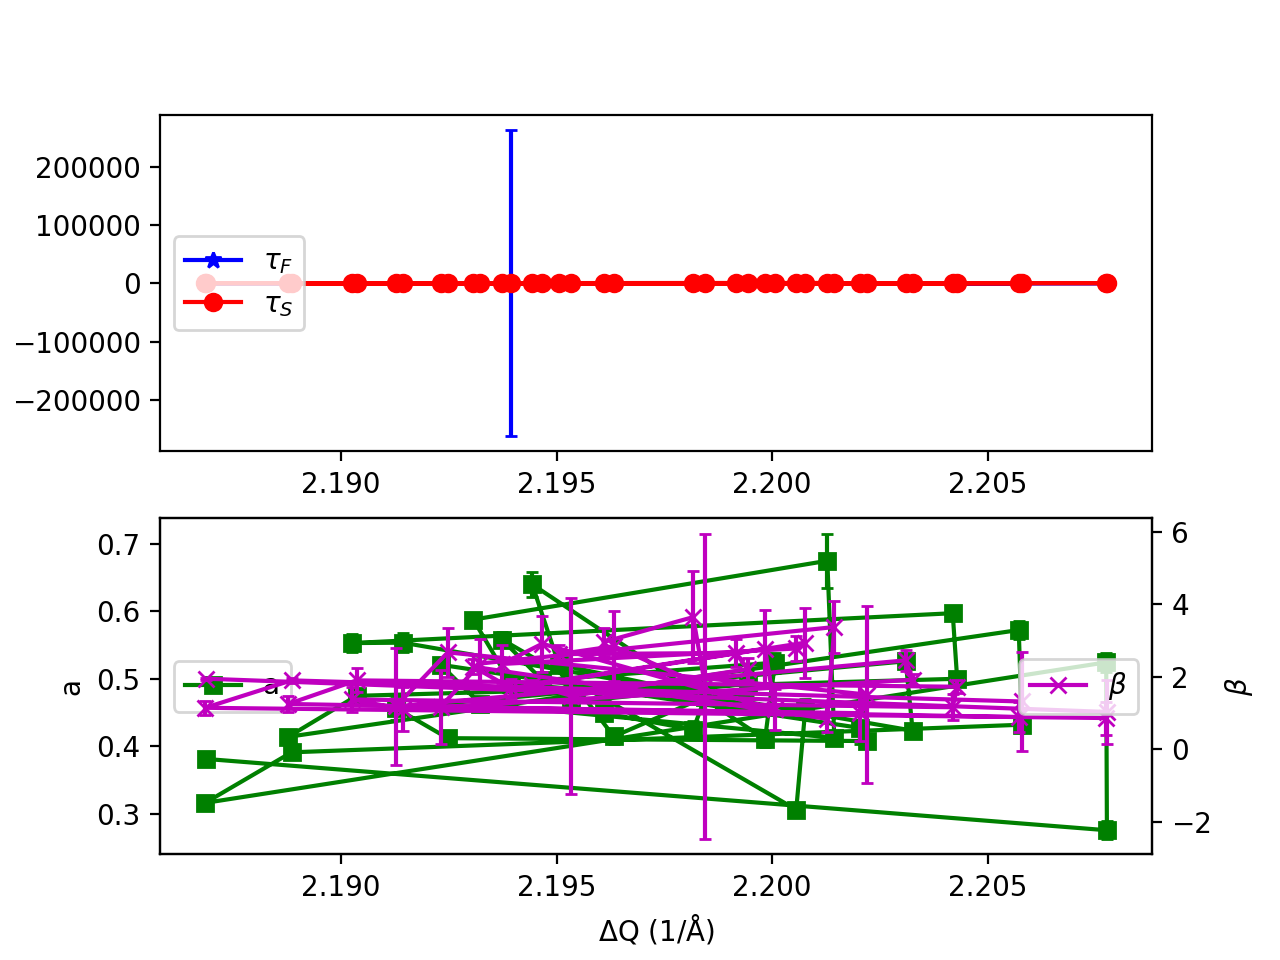

In [69]:

# Plotting 
fig, axs = plt.subplots(2,1)

# tau plot
axs[0].errorbar(dQ,taus[:,0], yerr=taus_err[:,0],fmt='none',ecolor='b',capsize=2)

axs[0].plot(dQ,taus[:,0],'b-*',label='$\\tau_F$')
axs[0].errorbar(dQ,taus[:,1], yerr=taus_err[:,1],fmt='none',ecolor='r',capsize=2)

axs[0].plot(dQ,taus[:,1],'r-o',label='$\\tau_S$')
#axs[0].set_xlabel('$\\Delta$Q (1/Å)')
axs[0].set_ylabel('$\\tau$ (s)')
axs[0].legend(loc = 'center left')
#axs[0].xaxis.set_visible(False)

# beta plot

axs2 = axs[1].twinx()
axs2.plot(dQ,betas,'m-x',label='$\\beta$')
axs2.errorbar(dQ,betas,yerr=betas_err,fmt='none',ecolor='m',capsize=2)

#axs[1].semilogy(dQ_sorted,betas_sorted[:,1],'r-o',label='$\\beta_2$')
axs2.set_xlabel('$\\Delta$Q (1/Å)')
axs2.set_ylabel('$\\beta$')
axs2.legend(loc = 'center right')

# a plot
axs[1].errorbar(dQ,aas,yerr=aas_err,fmt='none',ecolor='g',capsize=2)
axs[1].plot(dQ,aas,'g-s',label='a')
#axs[1].semilogy(dQ_sorted,betas_sorted[:,1],'r-o',label='$\\beta_2$')
axs[1].set_xlabel('$\\Delta$Q (1/Å)')
axs[1].set_ylabel('a')
axs[1].legend(loc = 'center left')

plt.show()

2.197840935671245


<IPython.core.display.Javascript object>


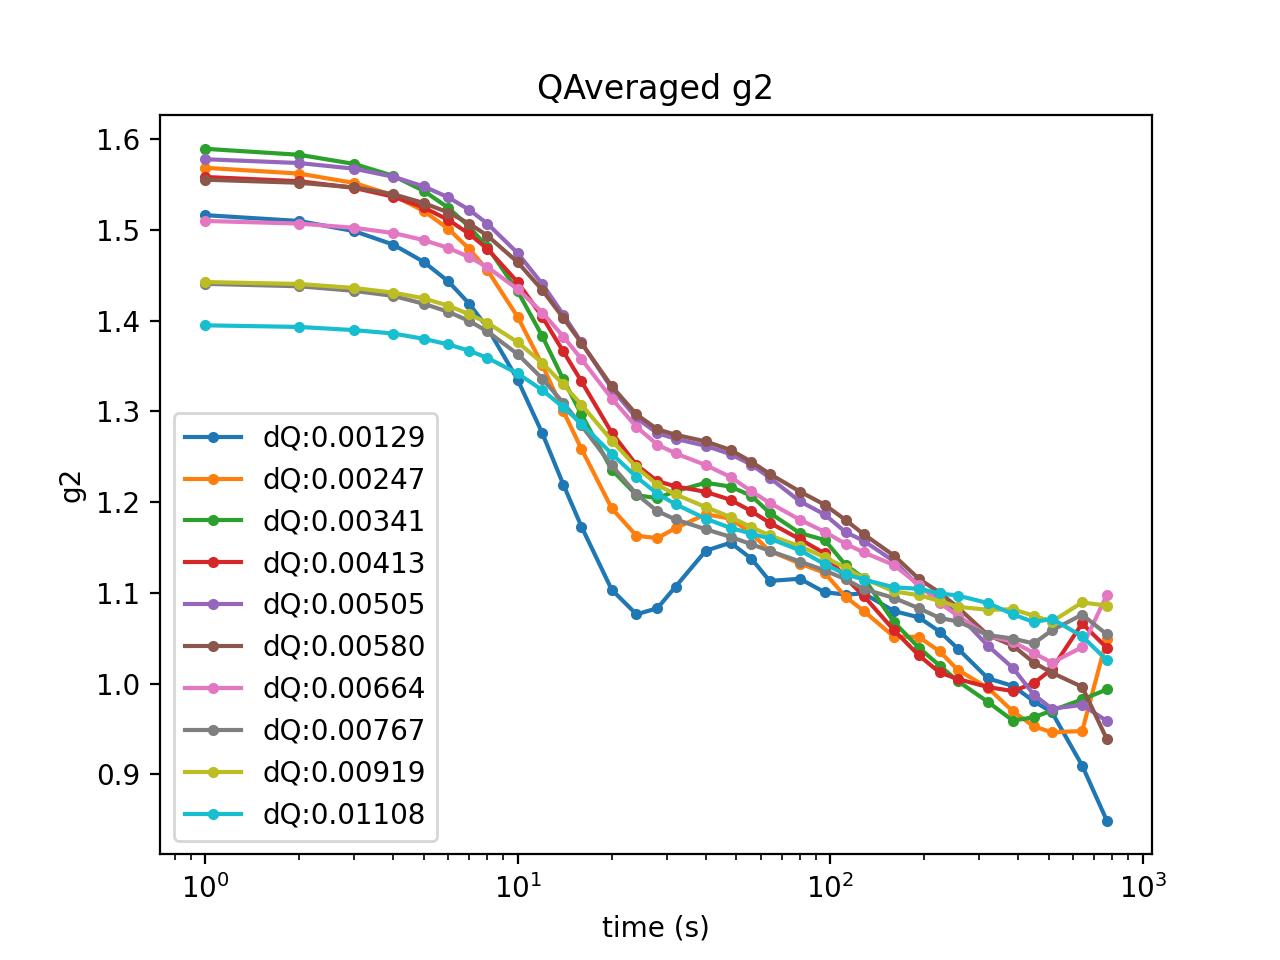

$\tau_1$:31.796 
 $\tau_2$:613.750
 $\beta$:1.985

$\tau_1$:31.796 
 $\tau_2$:613.750
 $\beta$:1.985

$\tau_1$:31.796 
 $\tau_2$:613.750
 $\beta$:1.985

$\tau_1$:31.796 
 $\tau_2$:613.750
 $\beta$:1.985

$\tau_1$:31.796 
 $\tau_2$:613.750
 $\beta$:1.985

$\tau_1$:31.796 
 $\tau_2$:613.750
 $\beta$:1.985

$\tau_1$:31.796 
 $\tau_2$:613.750
 $\beta$:1.985

$\tau_1$:31.796 
 $\tau_2$:613.750
 $\beta$:1.985

$\tau_1$:31.796 
 $\tau_2$:613.750
 $\beta$:1.985

$\tau_1$:31.796 
 $\tau_2$:613.750
 $\beta$:1.985



In [18]:
Q0 = np.mean(dQ[0:4])
print(Q0)
dQ = np.abs(dQ-Q0)

G2_QBin = np.mean(G2_result.reshape(numRings,G2_result.shape[0]//numRings,G2_result.shape[1]),axis=1)
G2err_QBin = np.mean(G2_error.reshape(numRings,G2_error.shape[0]//numRings,G2_error.shape[1]),axis=1)
dQ_QBin = np.mean(dQ.reshape(numRings,dQ.shape[0]//numRings),axis=1)
tau1_Qbin = np.mean(taus[:,0].reshape(numRings,taus[:,0].shape[0]//numRings),axis=1)
tau2_Qbin = np.mean(taus[:,1].reshape(numRings,taus[:,1].shape[0]//numRings),axis=1)
betas_Qbin = np.mean(betas.reshape(numRings,betas.shape[0]//numRings),axis=1)
As_Qbin = np.mean(As.reshape(numRings,As.shape[0]//numRings),axis=1)
aas_Qbin = np.mean(aas.reshape(numRings,aas.shape[0]//numRings),axis=1)
Cs_Qbin = np.mean(Cs.reshape(numRings,Cs.shape[0]//numRings),axis=1)


tau1err_Qbin = np.mean(taus_err[:,0].reshape(numRings,taus_err[:,0].shape[0]//numRings),axis=1)
tau2err_Qbin = np.mean(taus_err[:,1].reshape(numRings,taus_err[:,1].shape[0]//numRings),axis=1)
betaserr_Qbin = np.mean(betas_err.reshape(numRings,betas.shape[0]//numRings),axis=1)
aaserr_Qbin = np.mean(aas_err.reshape(numRings,aas_err.shape[0]//numRings),axis=1)
Aserr_Qbin = np.mean(As_err.reshape(numRings,As_err.shape[0]//numRings),axis=1)
Cserr_Qbin = np.mean(Cs_err.reshape(numRings,Cs_err.shape[0]//numRings),axis=1)


# Plotting
fig, ax = plt.subplots()

end = -5
for i in range(G2_QBin.shape[0]):
    #Fit Each G2(Q)
    C = np.min(G2_QBin[i,:end])
    A = np.max(G2_QBin[i,:end])-C
    #A2 = 0.5*A1
    a = 0.
    tt1 = 17
    tt2 = 227
    b = 1.9
    #b2 = 1.9

    #Fit the g2s
    #popt, pcov = curve_fit(g2_two_tau, delay[0,:end], G2_QBin[i,:end], p0=[C,A,a,tt1,tt2,b])
    
    #ax.errorbar(delay[0,:],QBinned_G2[i,:], yerr=G2err_QBin[i,:],fmt='none',capsize=2)
    #ax.errorbar(delay[0,:],np.mean(G2_result,axis=0), yerr=np.mean(G2_error,axis=0),fmt='none',ecolor='b',capsize=2)
    ax.semilogx(delay[0,:],G2_QBin[i,:],'.-',label='dQ:{:.5f}'.format(dQ_QBin[i]))
    #ax.semilogx(delay[0,:],g2_two_tau(delay[0,:],*popt),'r-')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('g2')
    ax.set_title('QAveraged g2')
    
    #label='C:{:.3f} \n A:{:.3f} \n a:{:.3f} \n $\\tau_1$:{:.3f} \n $\\tau_2$:{:.3f} '.format(popt[0],popt[1],popt[2],popt[3],popt[4],popt[5])
    print('$\\tau_1$:{:.3f} \n $\\tau_2$:{:.3f}\n $\\beta$:{:.3f}\n'.format(popt[3],popt[4],popt[5]))

plt.legend()


<IPython.core.display.Javascript object>


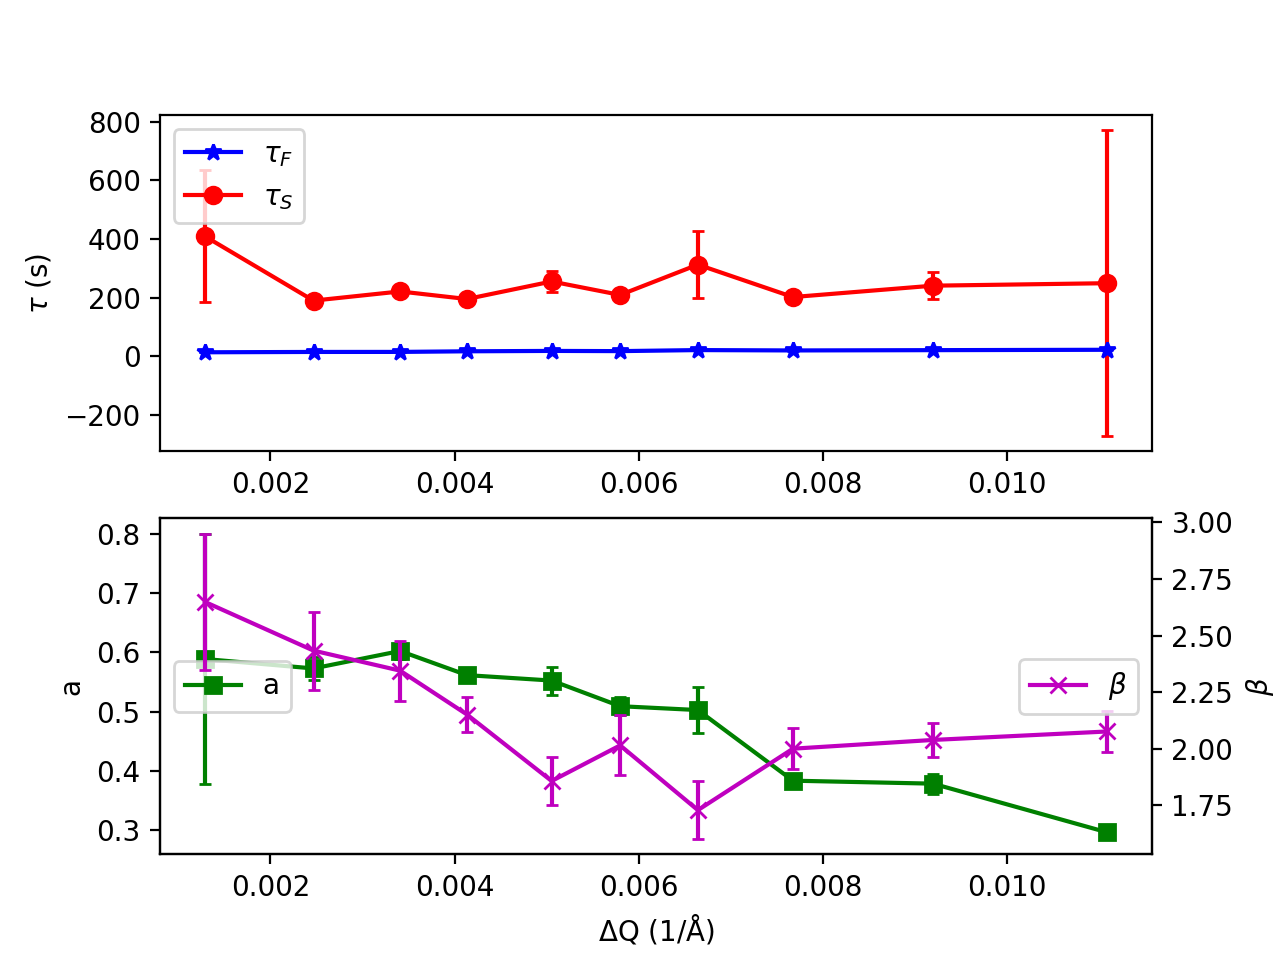

In [19]:


# Plotting 
fig, axs = plt.subplots(2,1)

# tau plot
axs[0].errorbar(dQ_QBin,tau1_Qbin, yerr=tau1err_Qbin,fmt='none',ecolor='b',capsize=2)
axs[0].errorbar(dQ_QBin,tau2_Qbin, yerr=tau2err_Qbin,fmt='none',ecolor='r',capsize=2)

axs[0].plot(dQ_QBin,tau1_Qbin,'b-*',label='$\\tau_F$')
axs[0].plot(dQ_QBin,tau2_Qbin,'r-o',label='$\\tau_S$')
#axs[0].set_xlabel('$\\Delta$Q (1/Å)')
axs[0].set_ylabel('$\\tau$ (s)')
axs[0].legend(loc = 'upper left')
#axs[0].xaxis.set_visible(False)

# beta plot

axs2 = axs[1].twinx()
axs2.plot(dQ_QBin,betas_Qbin,'m-x',label='$\\beta$')
#axs[1].semilogy(dQ_sorted,betas_sorted[:,1],'r-o',label='$\\beta_2$')
axs2.set_xlabel('$\\Delta$Q (1/Å)')
axs2.set_ylabel('$\\beta$')
axs2.legend(loc = 'center right')

axs[1].errorbar(dQ_QBin,aas_Qbin, yerr=aaserr_Qbin,fmt='none',ecolor='g',capsize=2)
axs2.errorbar(dQ_QBin,betas_Qbin, yerr=betaserr_Qbin,fmt='none',ecolor='m',capsize=2)

# a plot
axs[1].plot(dQ_QBin,aas_Qbin,'g-s',label='a')
#axs[1].semilogy(dQ_sorted,betas_sorted[:,1],'r-o',label='$\\beta_2$')
axs[1].set_xlabel('$\\Delta$Q (1/Å)')
axs[1].set_ylabel('a')
axs[1].legend(loc = 'center left')

plt.show()

<IPython.core.display.Javascript object>


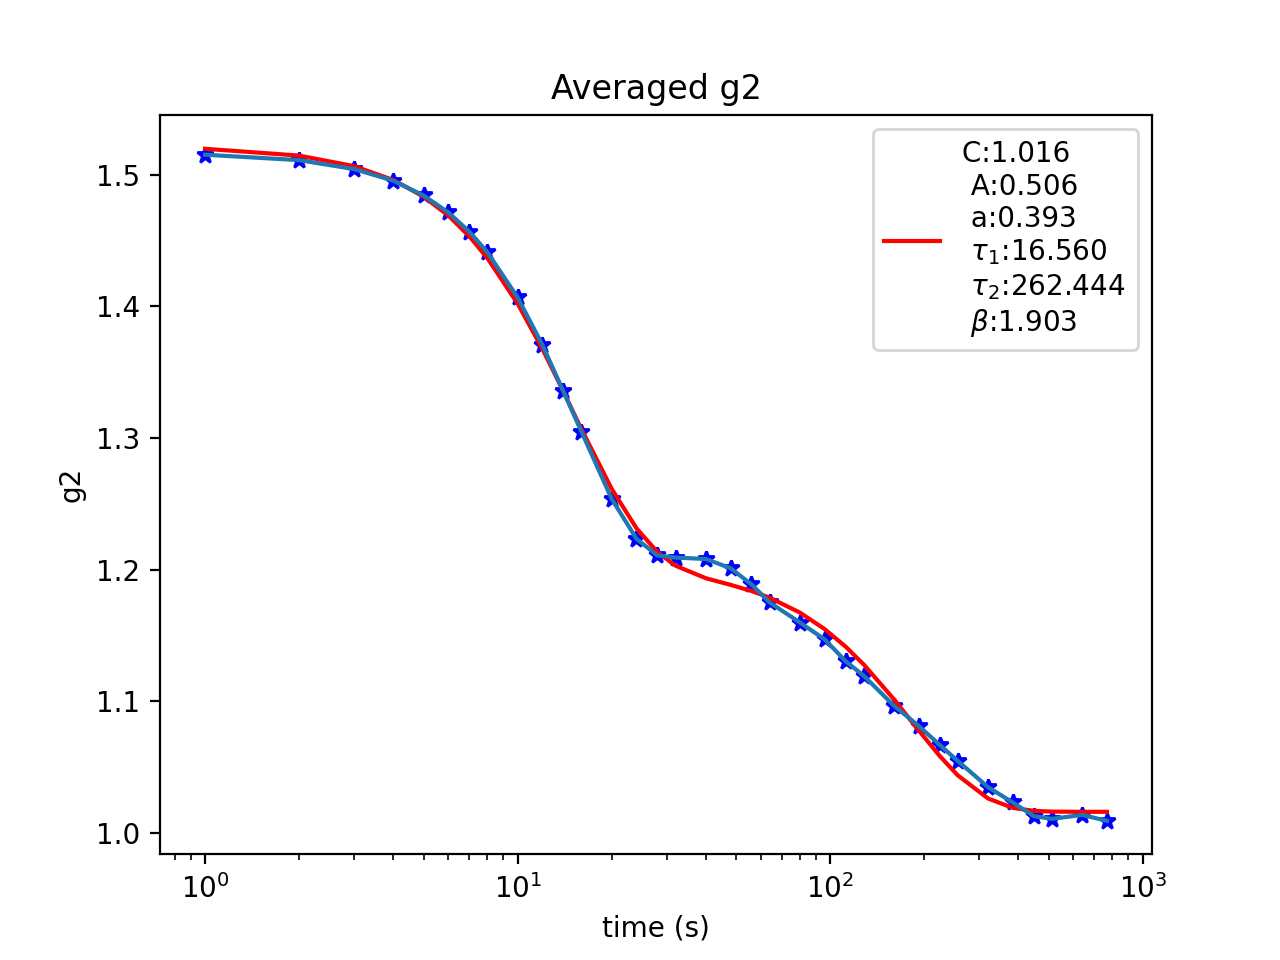

In [20]:
# Initial Guess
C = np.min(np.mean(G2_result,axis=0))
A = np.max(np.mean(G2_result,axis=0))
a = 0.5
tt1 = 17
tt2 = 446
b = 2.4

# Fit the average
popt, pcov = curve_fit(g2_two_tau, delay[0,:], np.mean(G2_result,axis=0), p0=[C,A,a,tt1,tt2,b])

# Plotting
fig, ax = plt.subplots()

#ax.errorbar(delay[0,:],np.mean(G2_result,axis=0), yerr=np.mean(G2_error,axis=0),fmt='none',ecolor='b',capsize=2)
ax.semilogx(delay[0,:],np.mean(G2_result,axis=0),'b*')
ax.semilogx(delay[0,:],g2_two_tau(delay[0,:],*popt),'r-',label='C:{:.3f} \n A:{:.3f} \n a:{:.3f} \n $\\tau_1$:{:.3f} \n $\\tau_2$:{:.3f} \n $\\beta$:{:.3f}'.format(popt[0],popt[1],popt[2],popt[3],popt[4],popt[5]))
ax.set_xlabel('time (s)')
ax.set_ylabel('g2')
ax.set_title('Averaged g2')


plt.legend()

<IPython.core.display.Javascript object>


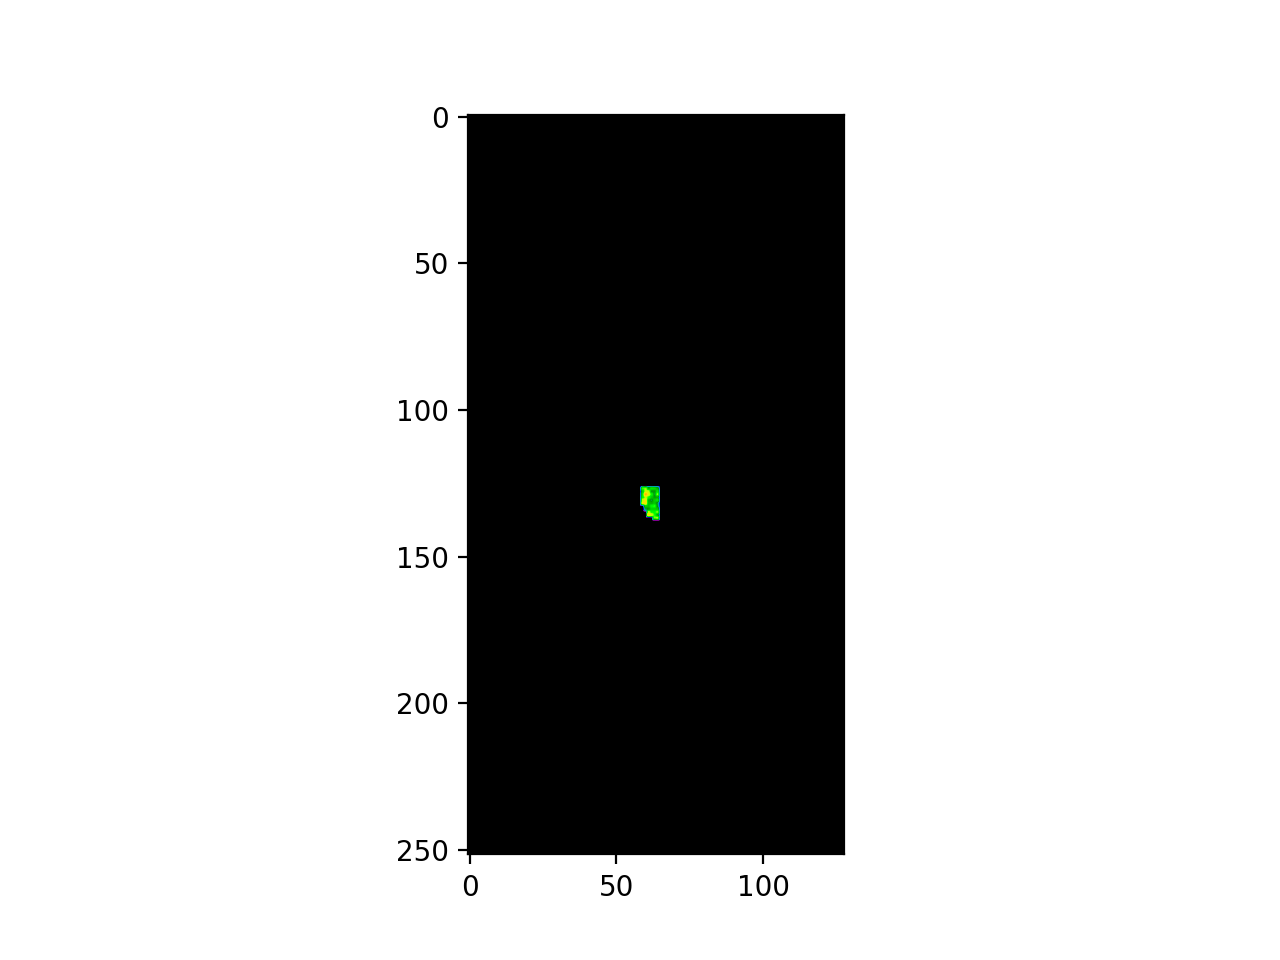

In [71]:
# Plot ROI
fig, ax = plt.subplots()

# Overlay the second image with a 'plasma' color scale and some transparency
ax.imshow(np.sum(det[0:1,:,:],axis=0)*masks[1,:,:]+1,cmap='nipy_spectral',norm=LogNorm(vmin=1, vmax=500))

# Display the plot
plt.show()

In [119]:
IMG_temp = det[:,masks[0,:,:]==1]/(np.mean(det[:,masks[0,:,:]==1])**2)
IMGS_NORM = IMG_temp.reshape((IMG_temp.shape[0],IMG_temp.shape[1],1))



C = twotime(IMGS_NORM)



<IPython.core.display.Javascript object>


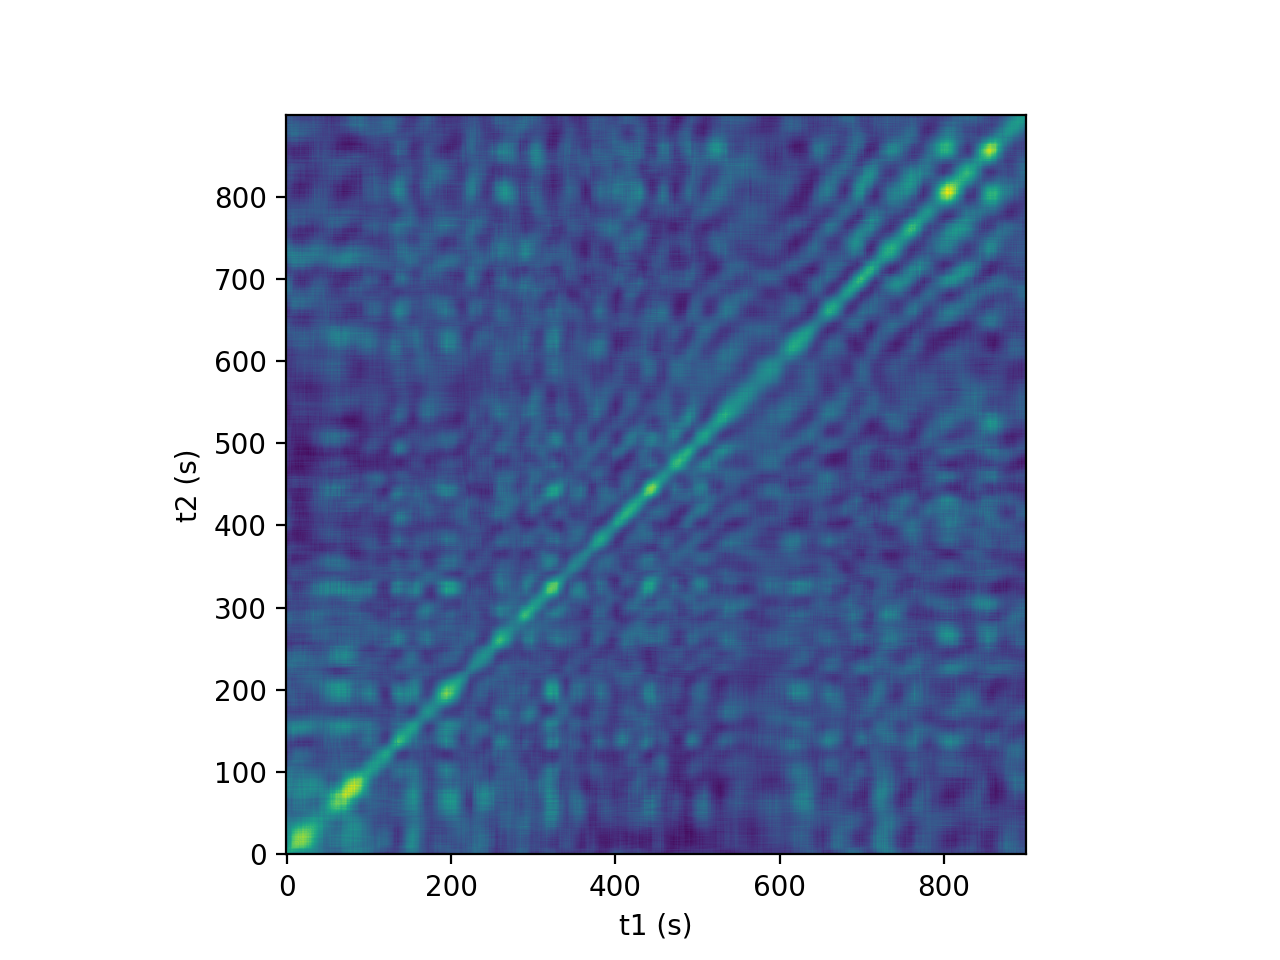

<function matplotlib.pyplot.show(*, block=None)>

In [120]:
import matplotlib.pyplot as plt
%matplotlib notebook

fig,ax = plt.subplots()
ax.set_ylabel('t2 (s)')
ax.set_xlabel('t1 (s)')
ax.imshow(C,origin="lower")
plt.show

# SAVE DATA

In [151]:
results = results_path+'part{}_temp_{}_scan{}_bin{}x{}_nr{}ns{}.npz'.format(Particle,Temperature,Scan,binSize,binSize,numRings,numSlices)

np.savez(results,G2_Results=G2_result,G2_error=G2_error,dQ=dQ,taus=taus,taus_err=taus_err,betas=betas,betas_err=betas_err,As=As,As_err=As_err,aas=aas,aas_err=aas_err,Cs=Cs, Cs_err=Cs_err,TwoTime=C)

# Plot All Results

In [45]:
results_path = '/Users/eriklamb/Documents/Data/PETRA/PETRA_P10_November2023/Beamtime_11017686/XPCS_Scans/Particle_2/Compiled_Results/'

files = os.listdir(results_path)
files = np.sort(files)
files=files[1:]
files

array(['part2_temp_298_scan219_bin5x5_nr10ns4.npz',
       'part2_temp_305_scan334_bin5x5_nr10ns4.npz',
       'part2_temp_325_scan552_bin5x5_nr10ns4.npz',
       'part2_temp_345_scan579_bin5x5_nr10ns4.npz',
       'part2_temp_350_scan868_bin5x5_nr10ns4.npz',
       'part2_temp_385_scan779_bin5x5_nr10ns4.npz',
       'part2_temp_405_scan796_bin5x5_nr10ns4.npz'], dtype='<U41')

In [46]:
data = np.load(results_path+files[0])
data['betas']

array([2.66696183, 2.69575198, 2.65154529, 2.71343936, 2.21209305,
       2.40326368, 2.36990968, 2.61504535, 1.97929946, 2.4306954 ,
       2.47457949, 2.21365521, 1.96094661, 2.17053855, 2.26435632,
       2.17603809, 1.7183719 , 1.30582391, 2.12460644, 2.03368308,
       2.17170981, 1.80813518, 2.20270698, 1.82404293, 1.69979025,
       1.61775477, 1.92333514, 1.67108763, 1.88875605, 1.89119015,
       2.05372602, 2.0630667 , 2.06182391, 2.18878509, 2.09414624,
       1.83631074, 2.15011317, 2.26831099, 1.81833922, 2.01726587])

<IPython.core.display.Javascript object>


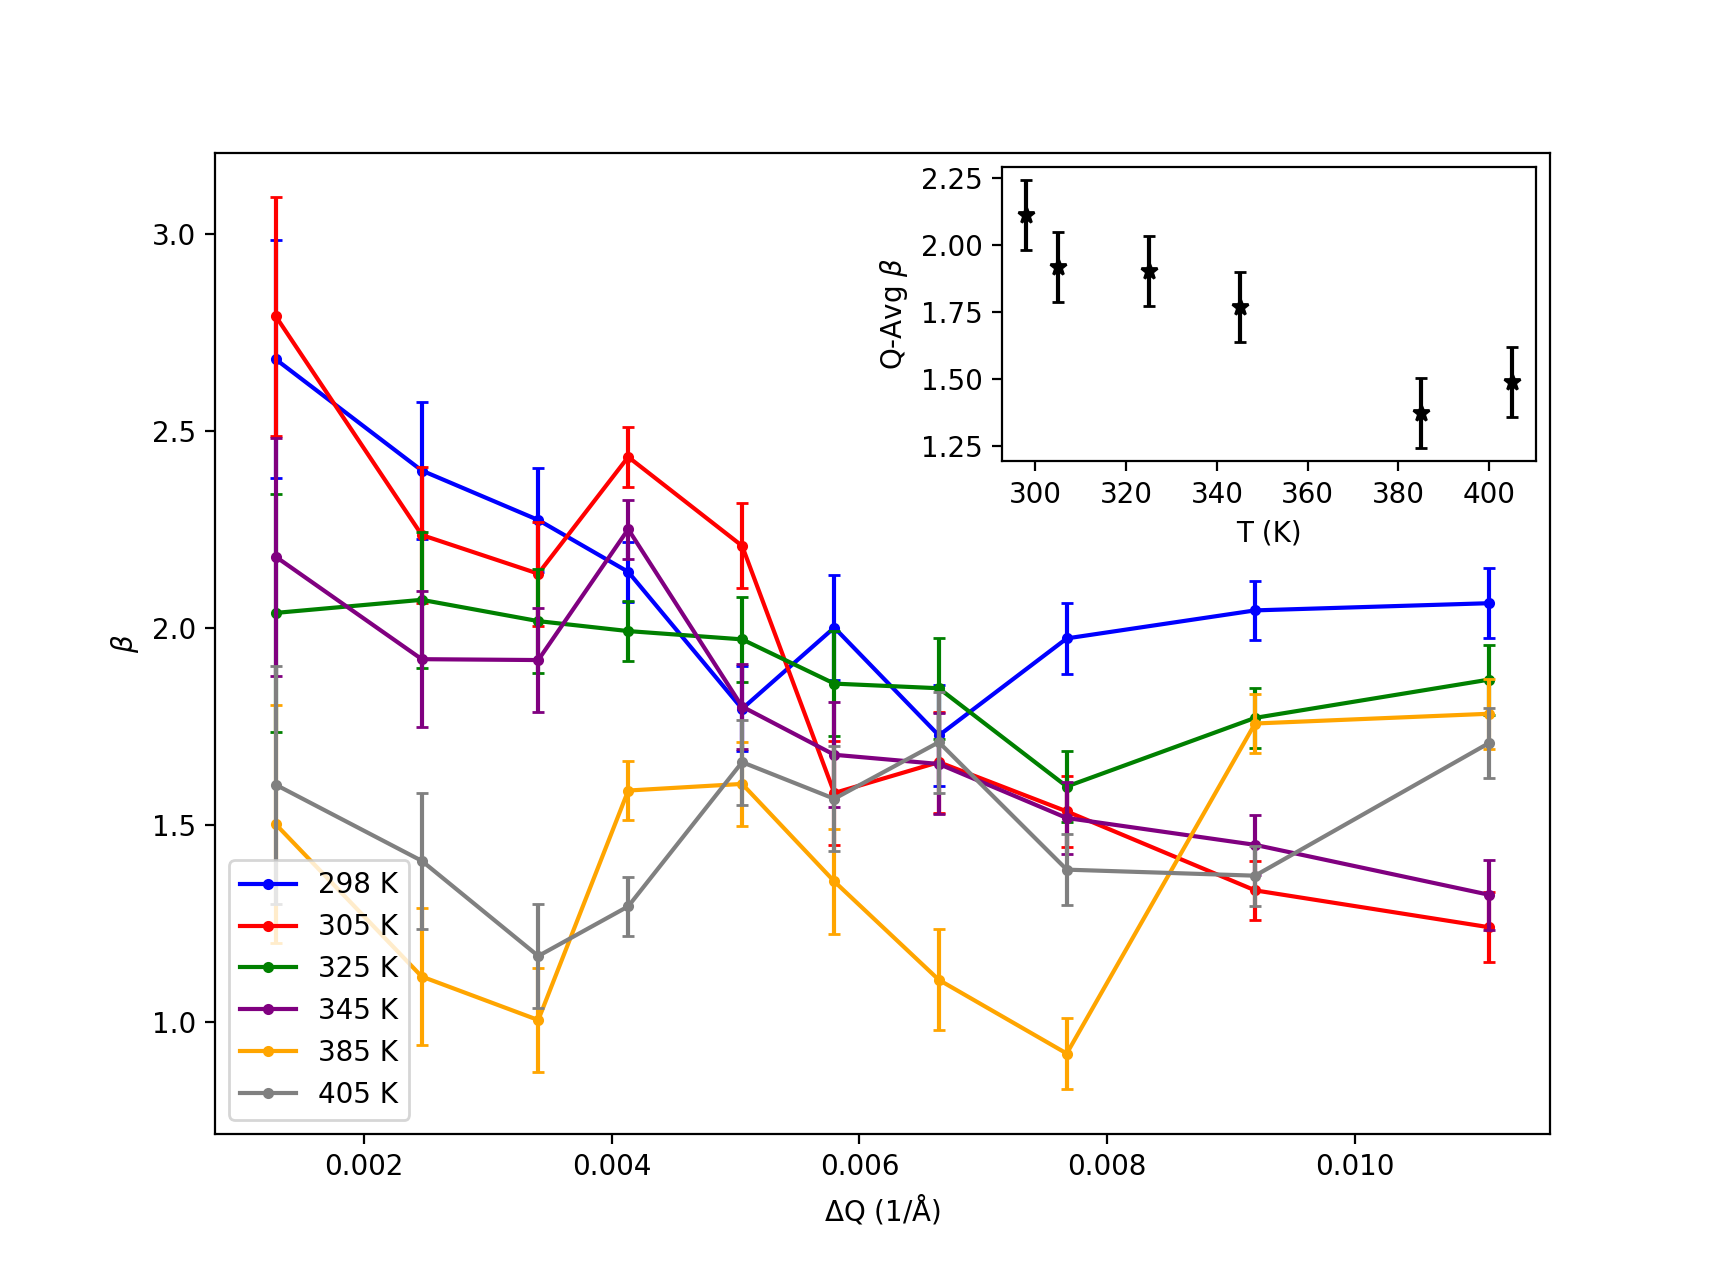

298
305
325
345
350
385
405


In [70]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots()
Temps = [298,305,325,345,385,405]
avgbeta = np.zeros(len(Temps))
avgbeta_error = np.zeros(len(Temps))
avgG2 = np.zeros((len(Temps),np.shape(delay[0,:])[0]))
colors = ['blue','red','green','purple','orange','grey']
i=0


for f in files:
    print(f[11:14])
    data = np.load(results_path+f)
    
    G2_result = data['G2_Results']
    
    if f[11:14]!='350':
        G2_QBin = np.mean(G2_result.reshape(numRings,G2_result.shape[0]//numRings,G2_result.shape[1]),axis=1)
        avgG2[i,:] += np.mean(G2_QBin,axis=0)
    
    betas = data['betas']
    beta_err = data['betas_err']
    
    betas_Qbin = np.mean(betas.reshape(numRings,betas.shape[0]//numRings),axis=1)
    betaserr_Qbin = np.mean(betas_err.reshape(numRings,betas.shape[0]//numRings),axis=1)
    
    taus = data['taus']
    
    tau1_Qbin = np.mean(taus[:,0].reshape(numRings,taus[:,0].shape[0]//numRings),axis=1)
    tau2_Qbin = np.mean(taus[:,1].reshape(numRings,taus[:,1].shape[0]//numRings),axis=1)

    if f[11:14]!='350':
        #Beta plot
        #ax.plot(dQ_QBin,betas_Qbin,'.-',label=f[11:14]+' K')
        ax.plot(dQ_QBin,betas_Qbin,'.-',color = colors[i],label=f[11:14]+' K')
        ax.errorbar(dQ_QBin,betas_Qbin, yerr=betaserr_Qbin,color = colors[i],fmt='none',capsize=2)
        ax.set_xlabel('$\\Delta$Q (1/Å)')
        ax.set_ylabel('$\\beta$')
        ax.legend(loc = 'lower left')
        
        avgbeta[i] +=np.mean(betas_Qbin)
        avgbeta_error[i] += np.mean(betaserr_Qbin)
        i+=1
        
        """""""""
        #tau1
        ax[1].plot(dQ_QBin,tau1_Qbin,'.-',label=f[11:14])
        #ax.errorbar(dQ_QBin,betas_Qbin, yerr=betaserr_Qbin,fmt='none',capsize=2)
        ax[1].set_xlabel('$\\Delta$Q (1/Å)')
        ax[1].set_ylabel('$\\tau_F$')
        ax[1].legend(loc = 'upper right')



        #tau2
        ax[2].plot(dQ_QBin,tau2_Qbin,'.-',label=f[11:14])
        #ax.errorbar(dQ_QBin,betas_Qbin, yerr=betaserr_Qbin,fmt='none',capsize=2)
        ax[2].set_xlabel('$\\Delta$Q (1/Å)')
        ax[2].set_ylabel('$\\tau_S$')
        ax[2].legend(loc = 'upper right')
        """""""""
        
inset_ax = inset_axes(ax, width="40%", height="30%", loc="upper right") 

inset_ax.plot(Temps, avgbeta, '*',color='black')
inset_ax.errorbar(Temps,avgbeta, yerr=avgbeta_error,color = 'black',fmt='none',capsize=2)


inset_ax.set_ylabel('Q-Avg $\\beta$')
inset_ax.set_xlabel('T (K)')

        
    
    #a.plot(data[])
    
plt.show()
    

<IPython.core.display.Javascript object>


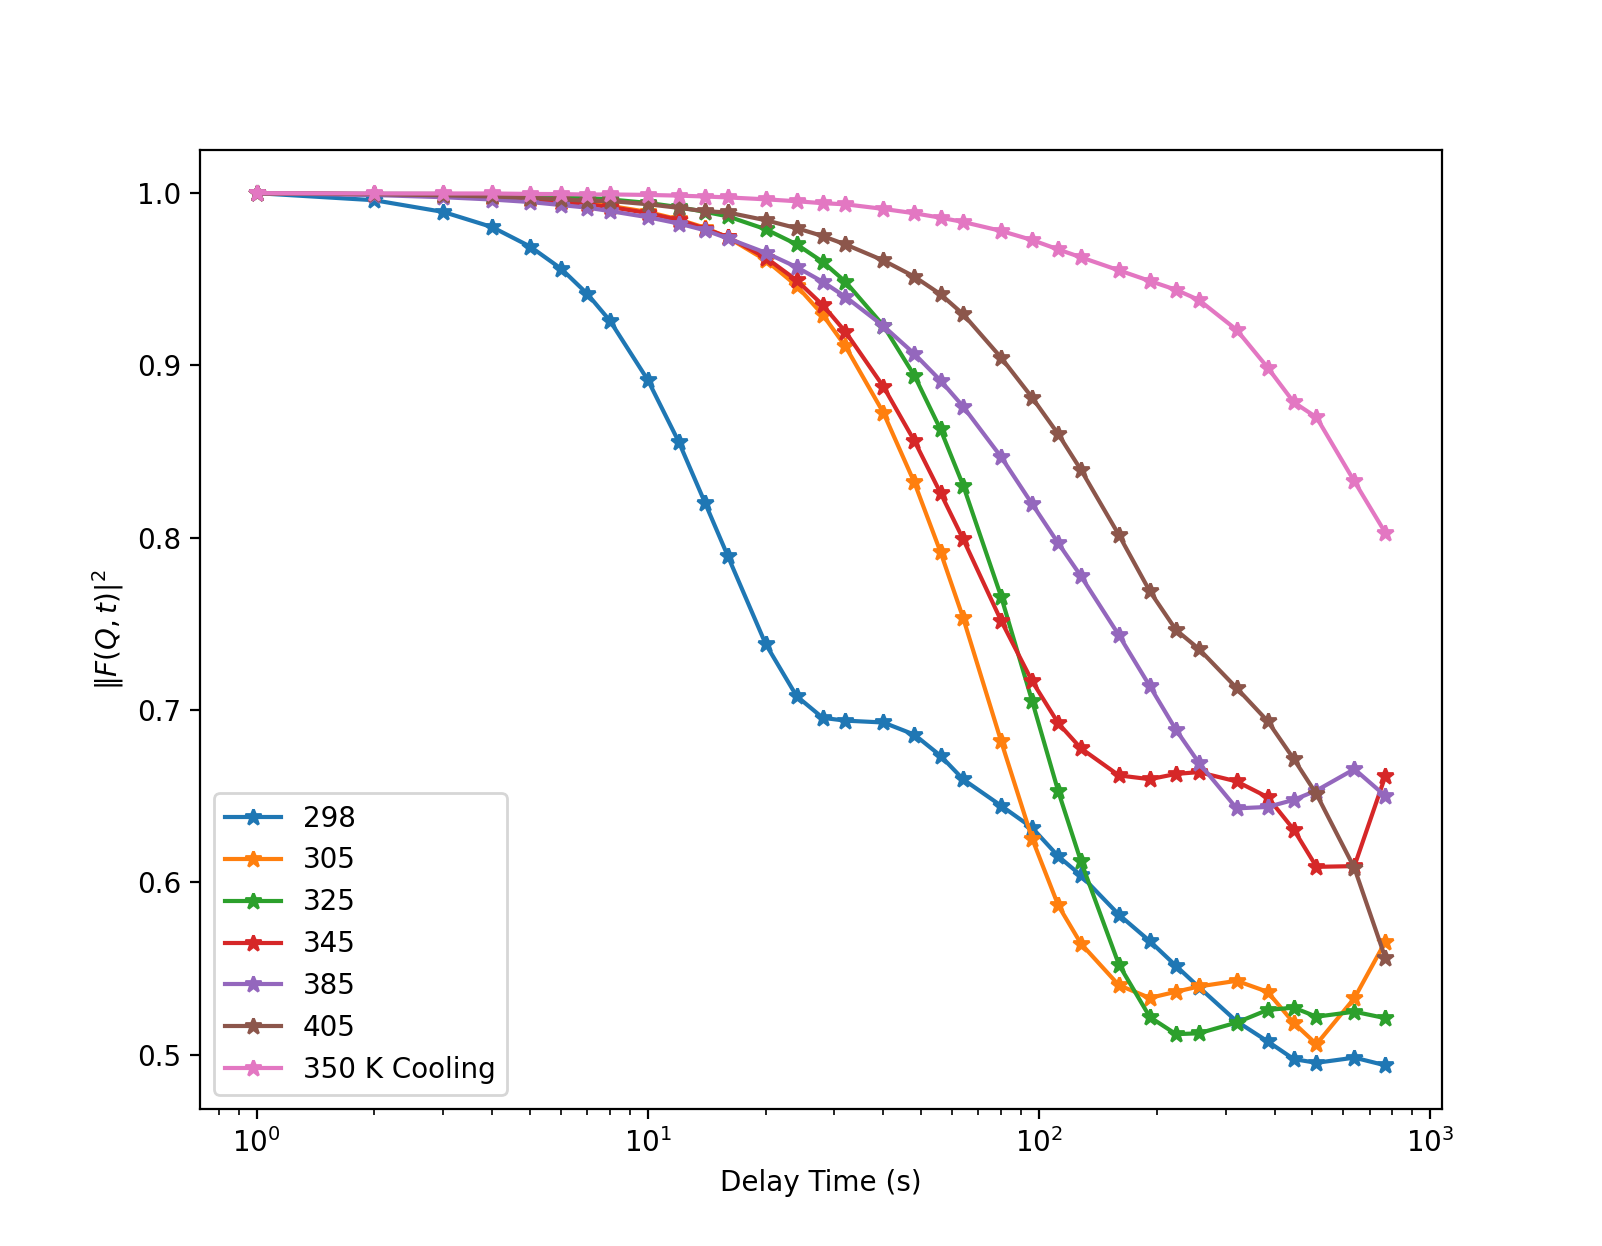

In [62]:
fig,ax = plt.subplots()


for T,g2s in zip(Temps,avgG2):
    ax.semilogx(delay[0,:],g2s-(np.max(g2s)-1),'*-',label=T)

data = np.load(results_path+'part2_temp_350_scan868_bin5x5_nr10ns4.npz')

new_g2 = np.mean(data['G2_Results'],axis=0)[:-2]
ax.semilogx(delay[0,:],new_g2 - (np.max(new_g2)-1),'*-',label = '350 K Cooling')

ax.set_ylabel('$\\|F(Q,t)|^2$')
ax.set_xlabel('Delay Time (s)')
ax.legend(loc='lower left')

plt.show()